# OCR using CNN

## Importing required libraries

In [1]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Tensorflow imported


Setting GPU memory growth limit to prevent Out of memory issues

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Dataset
Load dataset from dataset folder in grayscale format with image size 60x40 px

In [3]:
data = tf.keras.utils.image_dataset_from_directory('dataset',image_size=(60,40),color_mode="grayscale")

Found 210227 files belonging to 62 classes.


Image data iterator used to access images stored in batches

In [4]:
data_iter = data.as_numpy_iterator()
data_iter

Accessing next batch of images

In [5]:
batch = data_iter.next()

General lookup of how each batch variable looks and its shape <br>
Also the class names are printed

In [6]:
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [33 33 52 61 17 39 41 15 61 30 12 43 34 10  2 48 44 35 45 43 37 53 29  7
  3 35  8  6 43 19 42 60] (32, 60, 40, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


### Plotting data to check if the loading was right

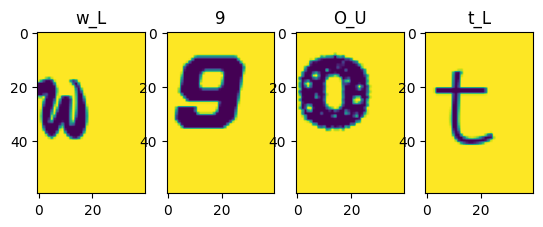

In [7]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
#print(img.shape)
#plt.imshow(img)

## Scale data
Scaling the image data from 0 to 1 so that tensorflow can run models in it properly

In [8]:
data = data.map(lambda x,y:(x/255,y))

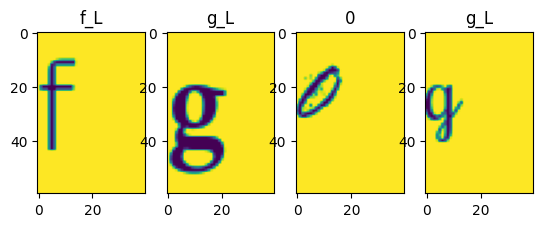

In [9]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [10]:
data_iter_val = data.as_numpy_iterator()

In [11]:
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[55 43 54 61 33 19 46  2 29 61  7  7 55 55  0 29  2 43 49 58 19 24 20 19
 58 37  0 22 36 55 54 23]


(32, 60, 40, 1)

## Splitting data
Train dataset size = 70% <br>
Testing dataset size = 20% <br>
Validation dataset size = 10%

In [12]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(f"Training dataset size: {train_size}\nVal. dataset size: {val_size}\nTest dataset size: {test_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 1314
Test dataset size: 657
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Training the Model!

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1 
  AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken
  
  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),
  
  Flatten(),
  Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 60, 40, 32)        320       
                                                                 
 average_pooling2d_6 (Averag  (None, 30, 20, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 18, 32)        9248      
                                                                 
 average_pooling2d_7 (Averag  (None, 14, 9, 32)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 7, 32)         9248      
                                                                 
 average_pooling2d_8 (Averag  (None, 6, 3, 32)        

In [27]:
# Define a Callback class that stops training once accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [28]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [29]:
#Fit the model
history = model.fit(train,
                    epochs=10,
                    steps_per_epoch=len(train),
                    validation_data=val,
                    callbacks=[ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.h5",save_best_only=True),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
4599/4599 [==============================] - 130s 28ms/step - loss: 1.0006 - accuracy: 0.7637 - val_loss: 0.6465 - val_accuracy: 0.8383
Epoch 2/10
4599/4599 [==============================] - 125s 27ms/step - loss: 0.5463 - accuracy: 0.8621 - val_loss: 0.5111 - val_accuracy: 0.8706
Epoch 3/10
4599/4599 [==============================] - 121s 26ms/step - loss: 0.4569 - accuracy: 0.8822 - val_loss: 0.4557 - val_accuracy: 0.8825
Epoch 4/10
4599/4599 [==============================] - 125s 27ms/step - loss: 0.4077 - accuracy: 0.8917 - val_loss: 0.4401 - val_accuracy: 0.8843
Epoch 5/10
4599/4599 [==============================] - 119s 26ms/step - loss: 0.3743 - accuracy: 0.8990 - val_loss: 0.4281 - val_accuracy: 0.8865
Epoch 6/10
4599/4599 [==============================] - 130s 28ms/step - loss: 0.3501 - accuracy: 0.9046 - val_loss: 0.4046 - val_accuracy: 0.8953
Epoch 7/10
4599/4599 [==============================] - 120s 26ms/step - loss: 0.3313 - accuracy: 0.9084 - val_loss: 0

In [30]:
#model_baseline.save("second_try.h5")

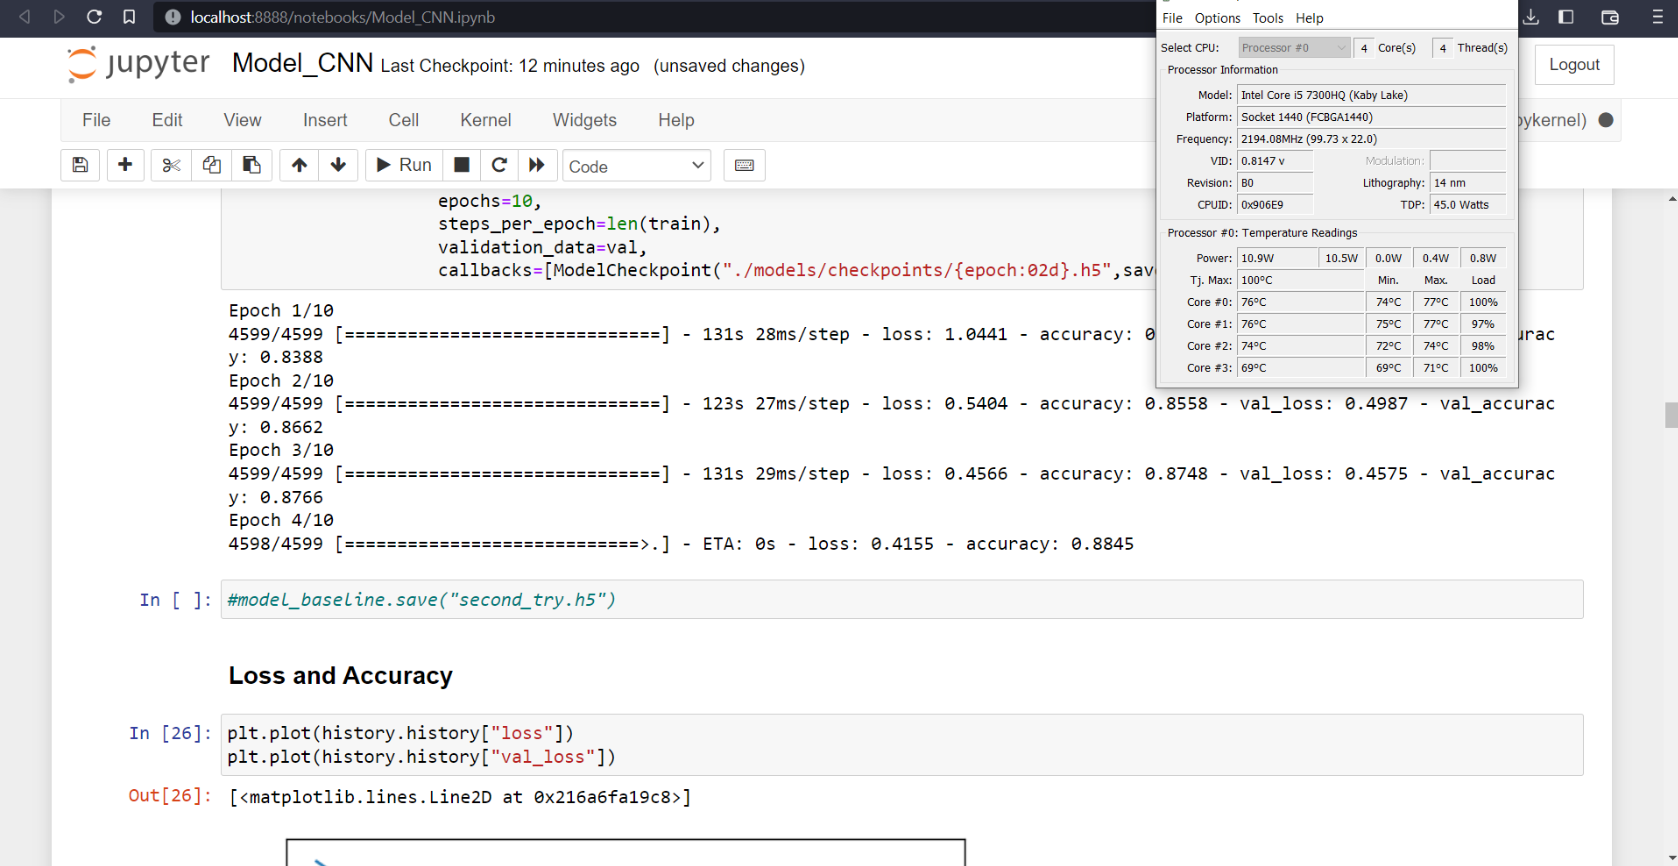

### Loss and Accuracy

In [34]:
epochs = [*range(1,11)]
plt.style.use(["science","no-latex","grid"])

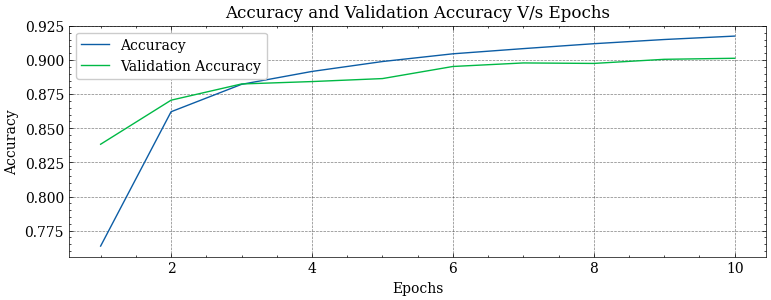

In [35]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["accuracy"])
ax.plot(epochs,history.history["val_accuracy"])
ax.legend(["Accuracy","Validation Accuracy"])
ax.set_title("Accuracy and Validation Accuracy V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.savefig("./models/model_perf/acc_plt.png",dpi=400)
plt.show(); plt.close()

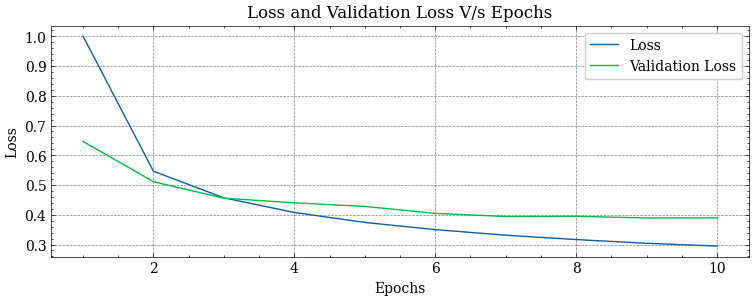

In [36]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["loss"])
ax.plot(epochs,history.history["val_loss"])
ax.legend(["Loss","Validation Loss"])
ax.set_title("Loss and Validation Loss V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.savefig("./models/model_perf/loss_plt.png",dpi=400)
plt.show(); plt.close()

### Evaluate

In [37]:
from tensorflow.keras.models import load_model

In [39]:
loaded_model = load_model("models/checkpoints_new/09.h5")

In [40]:
eval_data = loaded_model.evaluate(test)

657/657 [==============================] - 70s 14ms/step - loss: 0.3912 - accuracy: 0.8980


In [41]:
print(eval_data)

[0.39118921756744385, 0.8979582190513611]


In [42]:
# data_iter_val = test.as_numpy_iterator()
# test_batch = data_iter_val.next()
# print(test_batch)
predictions = np.array([])
labels = np.array([])

for x,y in test:
    predictions = np.concatenate([predictions,np.argmax(loaded_model.predict(x),axis=-1)])
    labels = np.concatenate([labels,y.numpy()])

#     print(y.numpy())
#     labels =  np.concatenate([labels,np.argmax(y.numpy(),axis=-1)])

In [43]:
print(predictions,labels)

[54. 48. 60. ... 55.  7.  5.] [54. 20. 60. ... 55.  7.  5.]


In [44]:
import seaborn as sns

In [45]:
conf_mat = tf.math.confusion_matrix(labels,predictions)

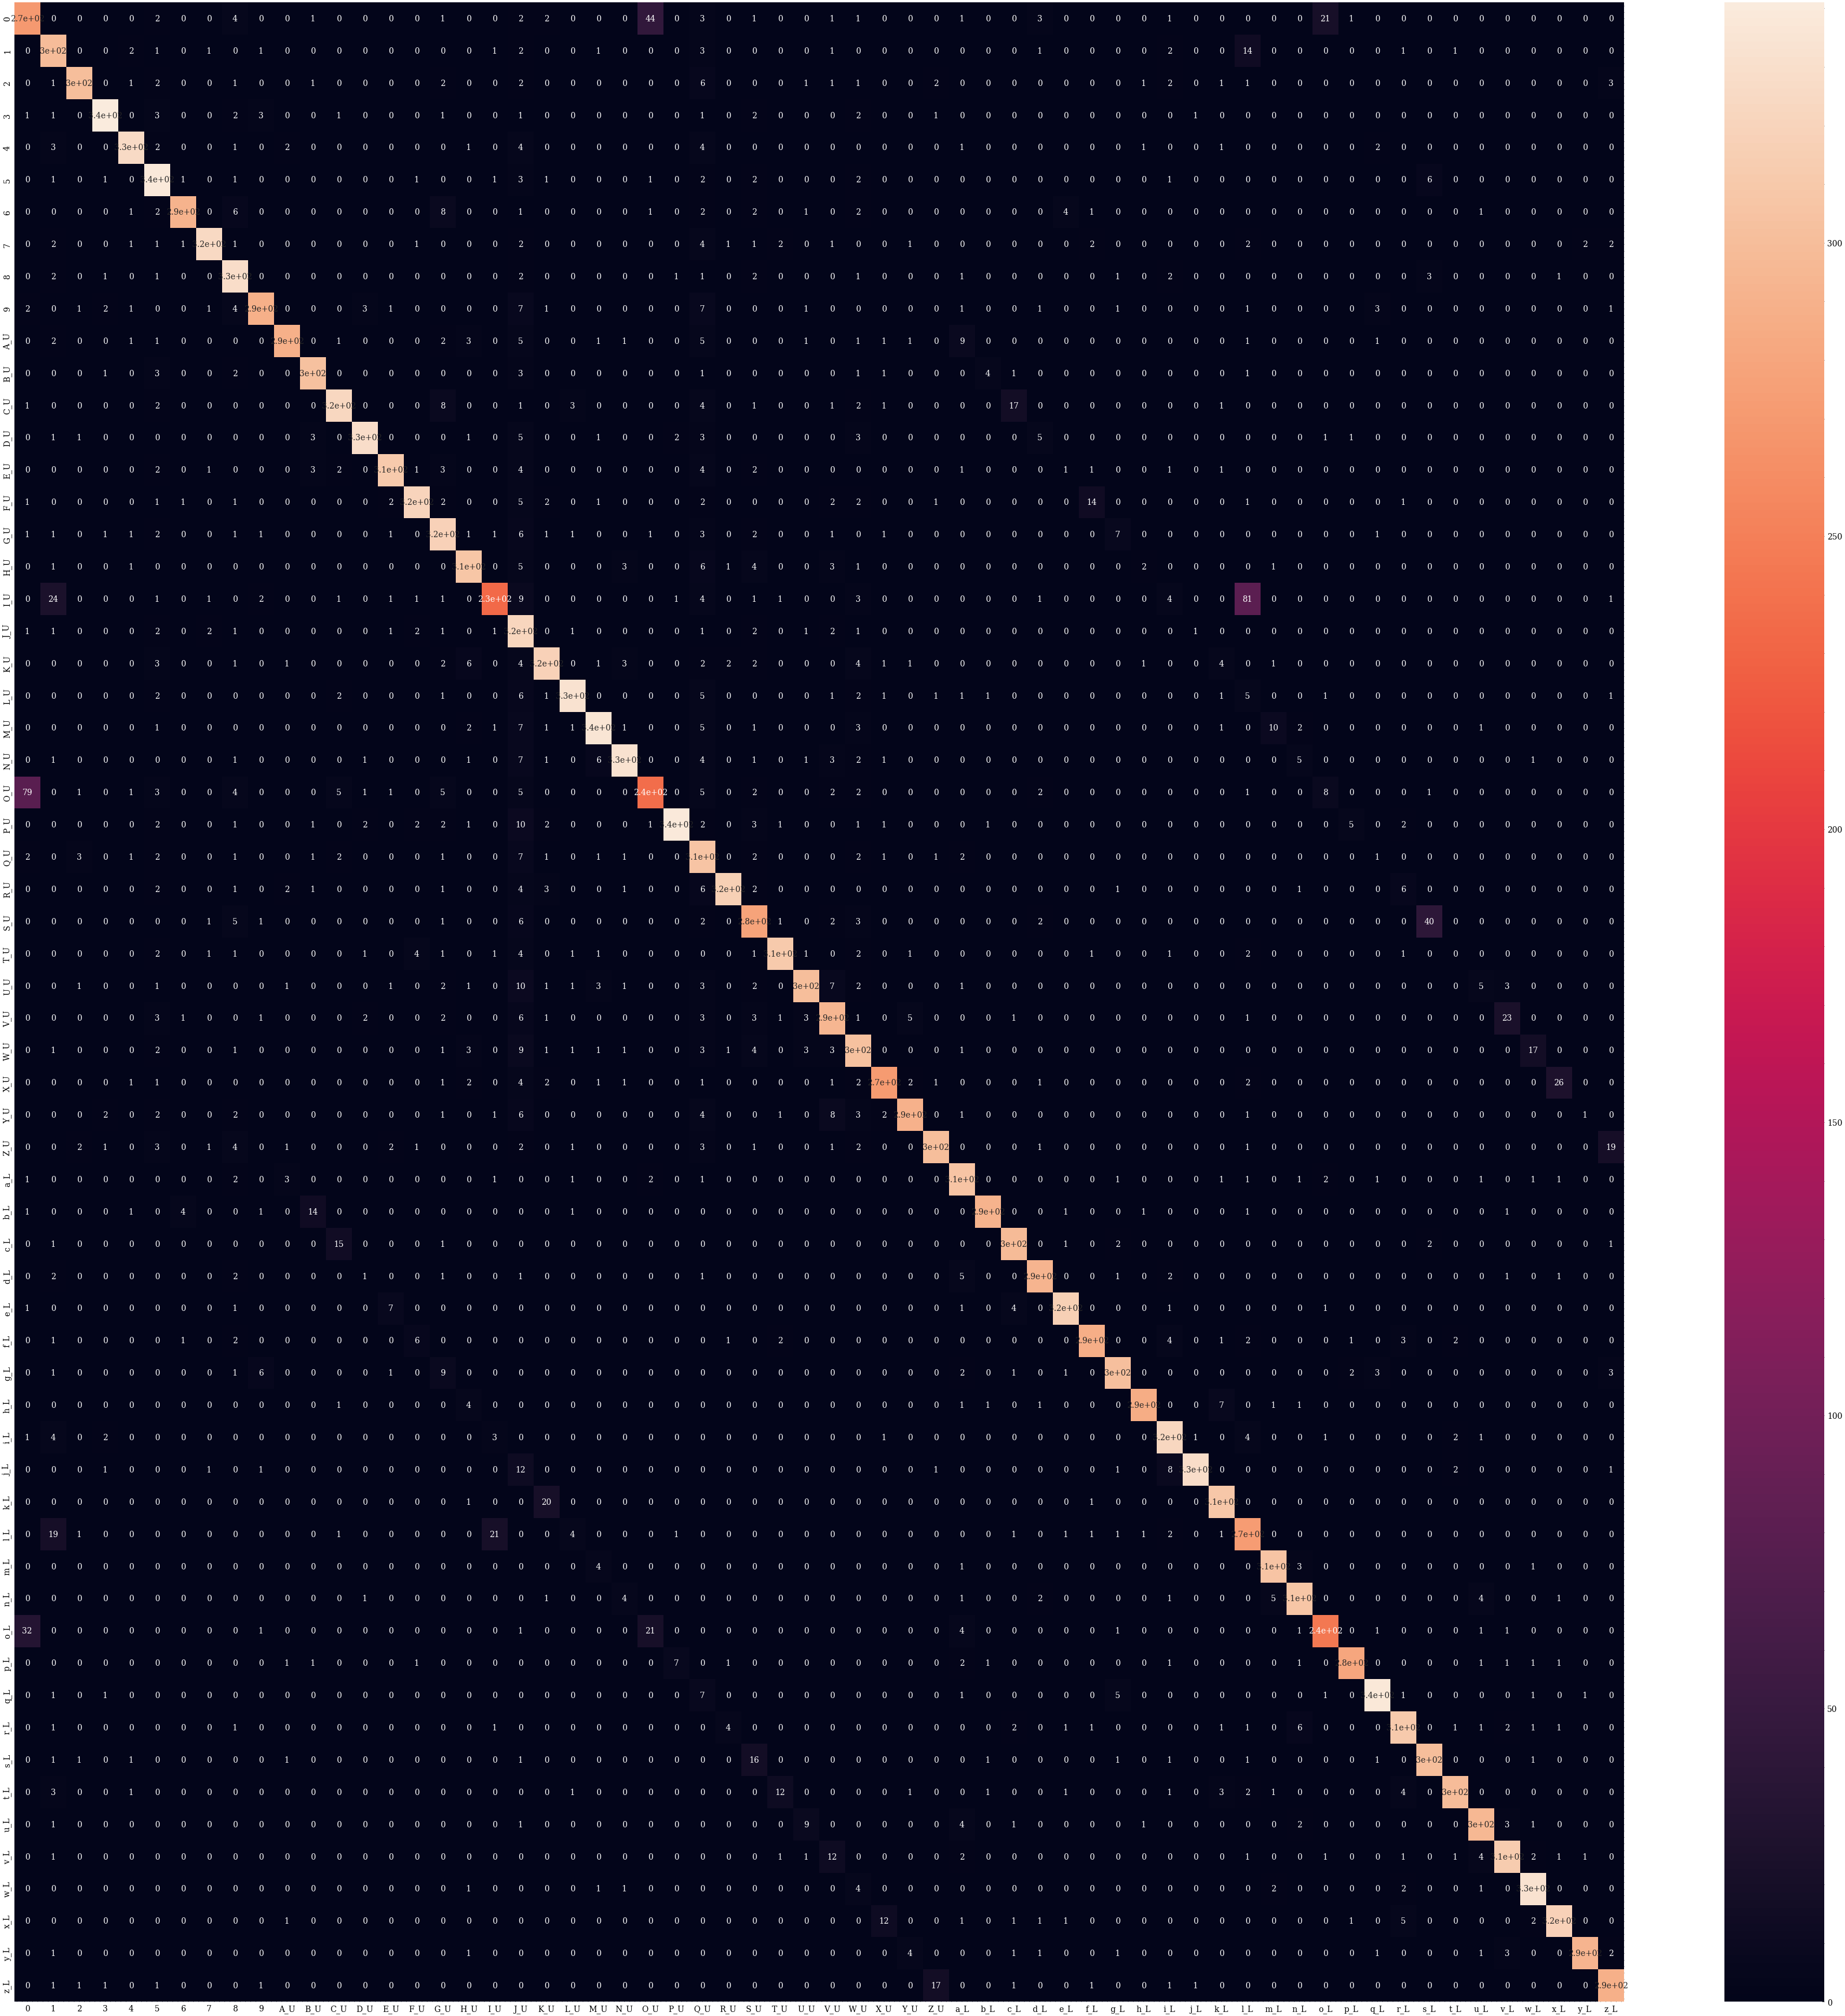

In [47]:
fig, ax = plt.subplots(figsize=(45,45))
sns.heatmap(conf_mat,ax=ax,annot=True)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("./models/conf_matrix_new.png",dpi=400)

### Random Test

In [48]:
import random

In [49]:
def load_random():
    ranges = [*range(0,1000,1)]
    values = random.choices(ranges,k=62)
    images = list()
    for i in range(len(values)):
        if i<10:
            img = cv2.imread(f"./dataset/{i}/{values[i]}.png")
        else:
            img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{values[i]}.png")
        if img is not None:
            images.append(img)
        else:
            if i<10:
                img = cv2.imread(f"./dataset/{i}/1.png")
            else:
                img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_1.png")
#             while True:
#                 val = values[i]
#                 if i<10:
#                     img = cv2.imread(f"./dataset/{i}/{val+1}.png")
#                 else:
#                     print("whoa")
#                     img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{val+1}.png")
#                 if img is not None:
#                     break
#                 else:
#                     val +=1
    return images
        
    
def plot_those_imgs(images,**kwargs):
    fig, ax = plt.subplots(8,8,figsize=(16,16))
    fig.tight_layout()
    for i in range(len(images)):
        ax[i//8,i%8].imshow(images[i])
        if len(kwargs)==0:
            ax[i//8,i%8].title.set_text(f"{class_names[i]}")
        else:
            ax[i//8,i%8].title.set_text(f"{class_names[i]} - {kwargs['acc'][i]}")
    plt.show()

61


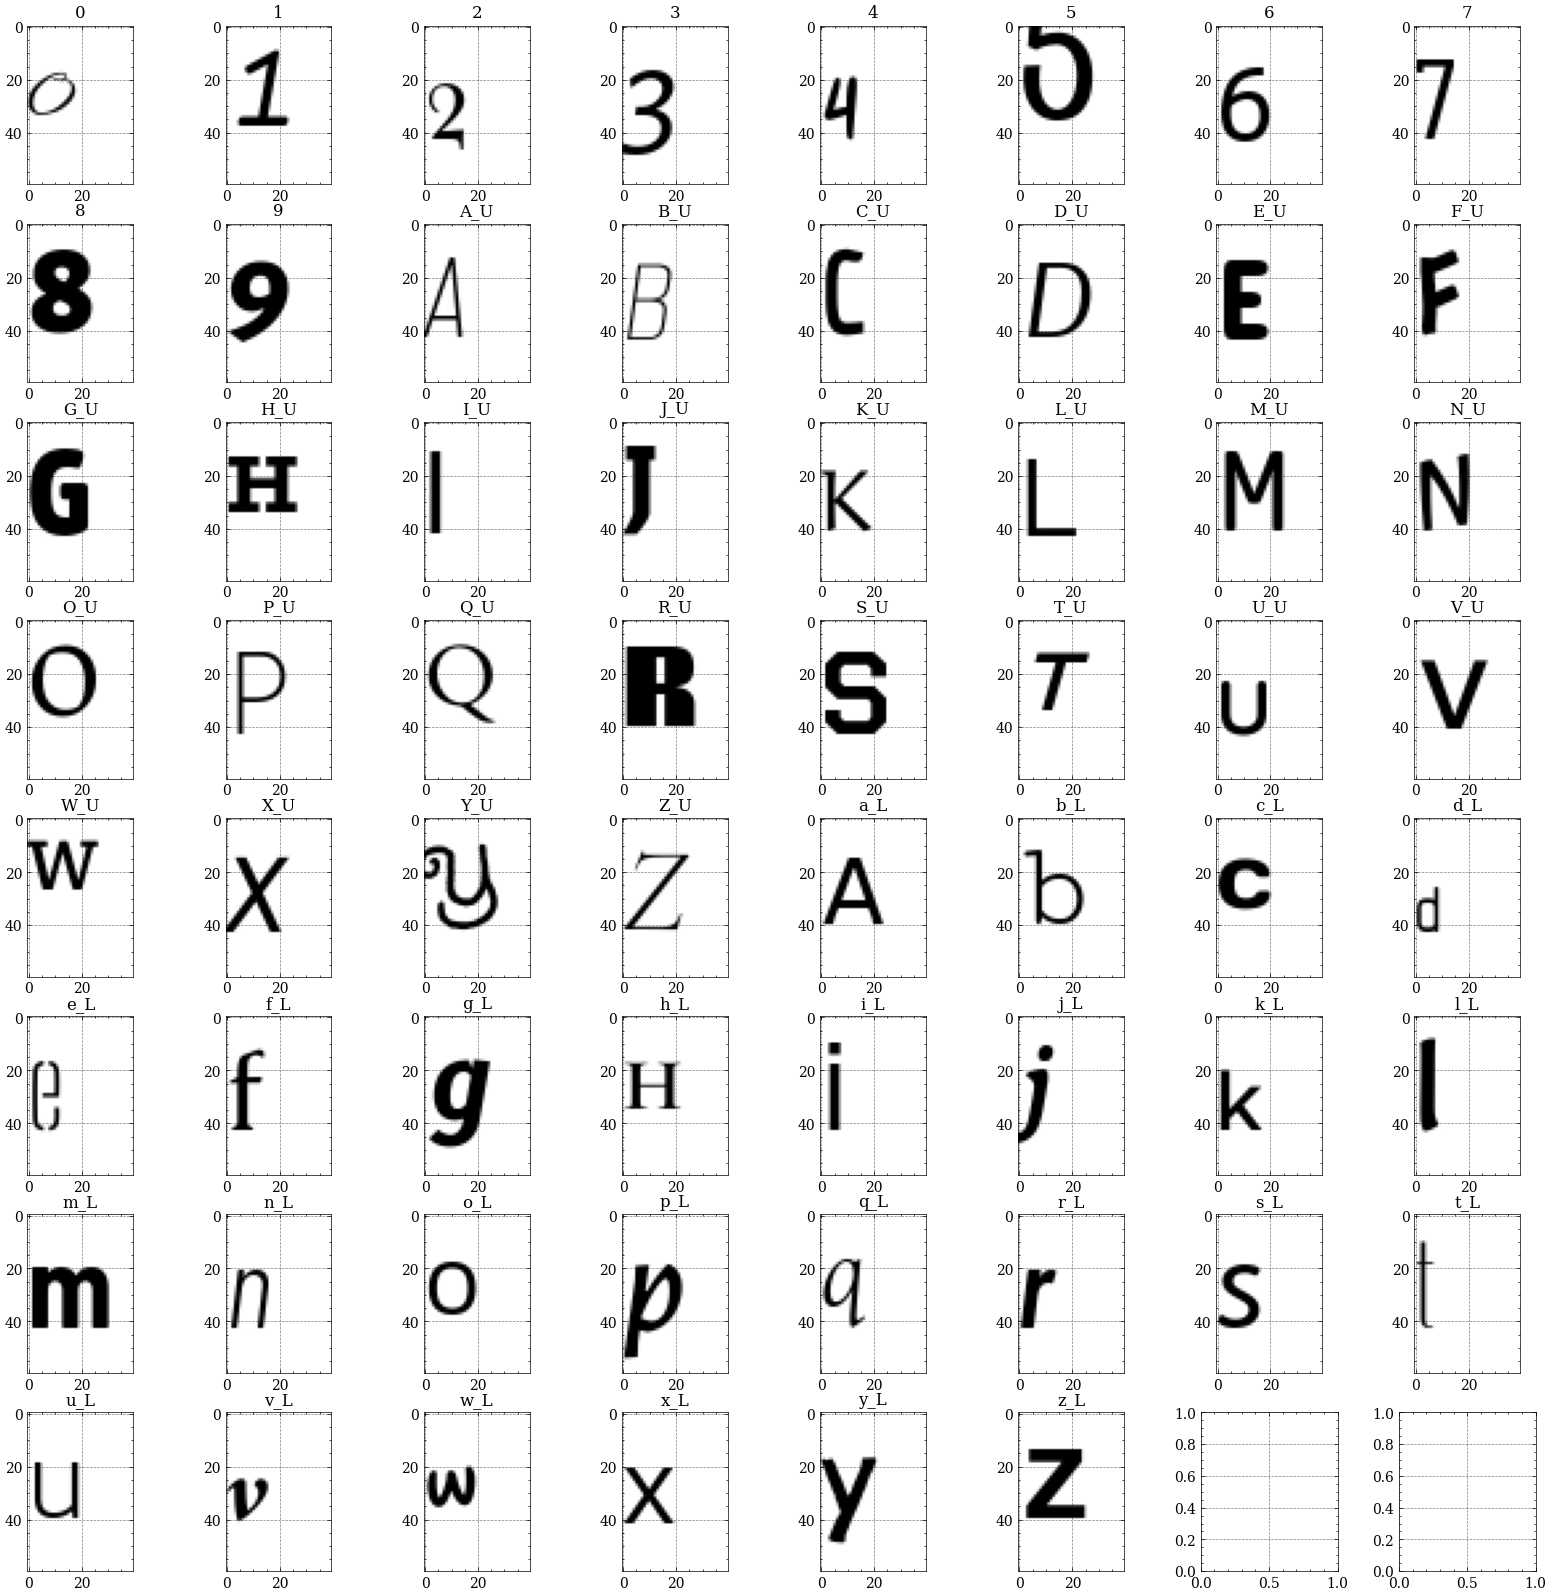

In [50]:
while True:
    images = load_random()
    if len(images)==62:
        break
    print(len(images))

plot_those_imgs(images)

plt.close()

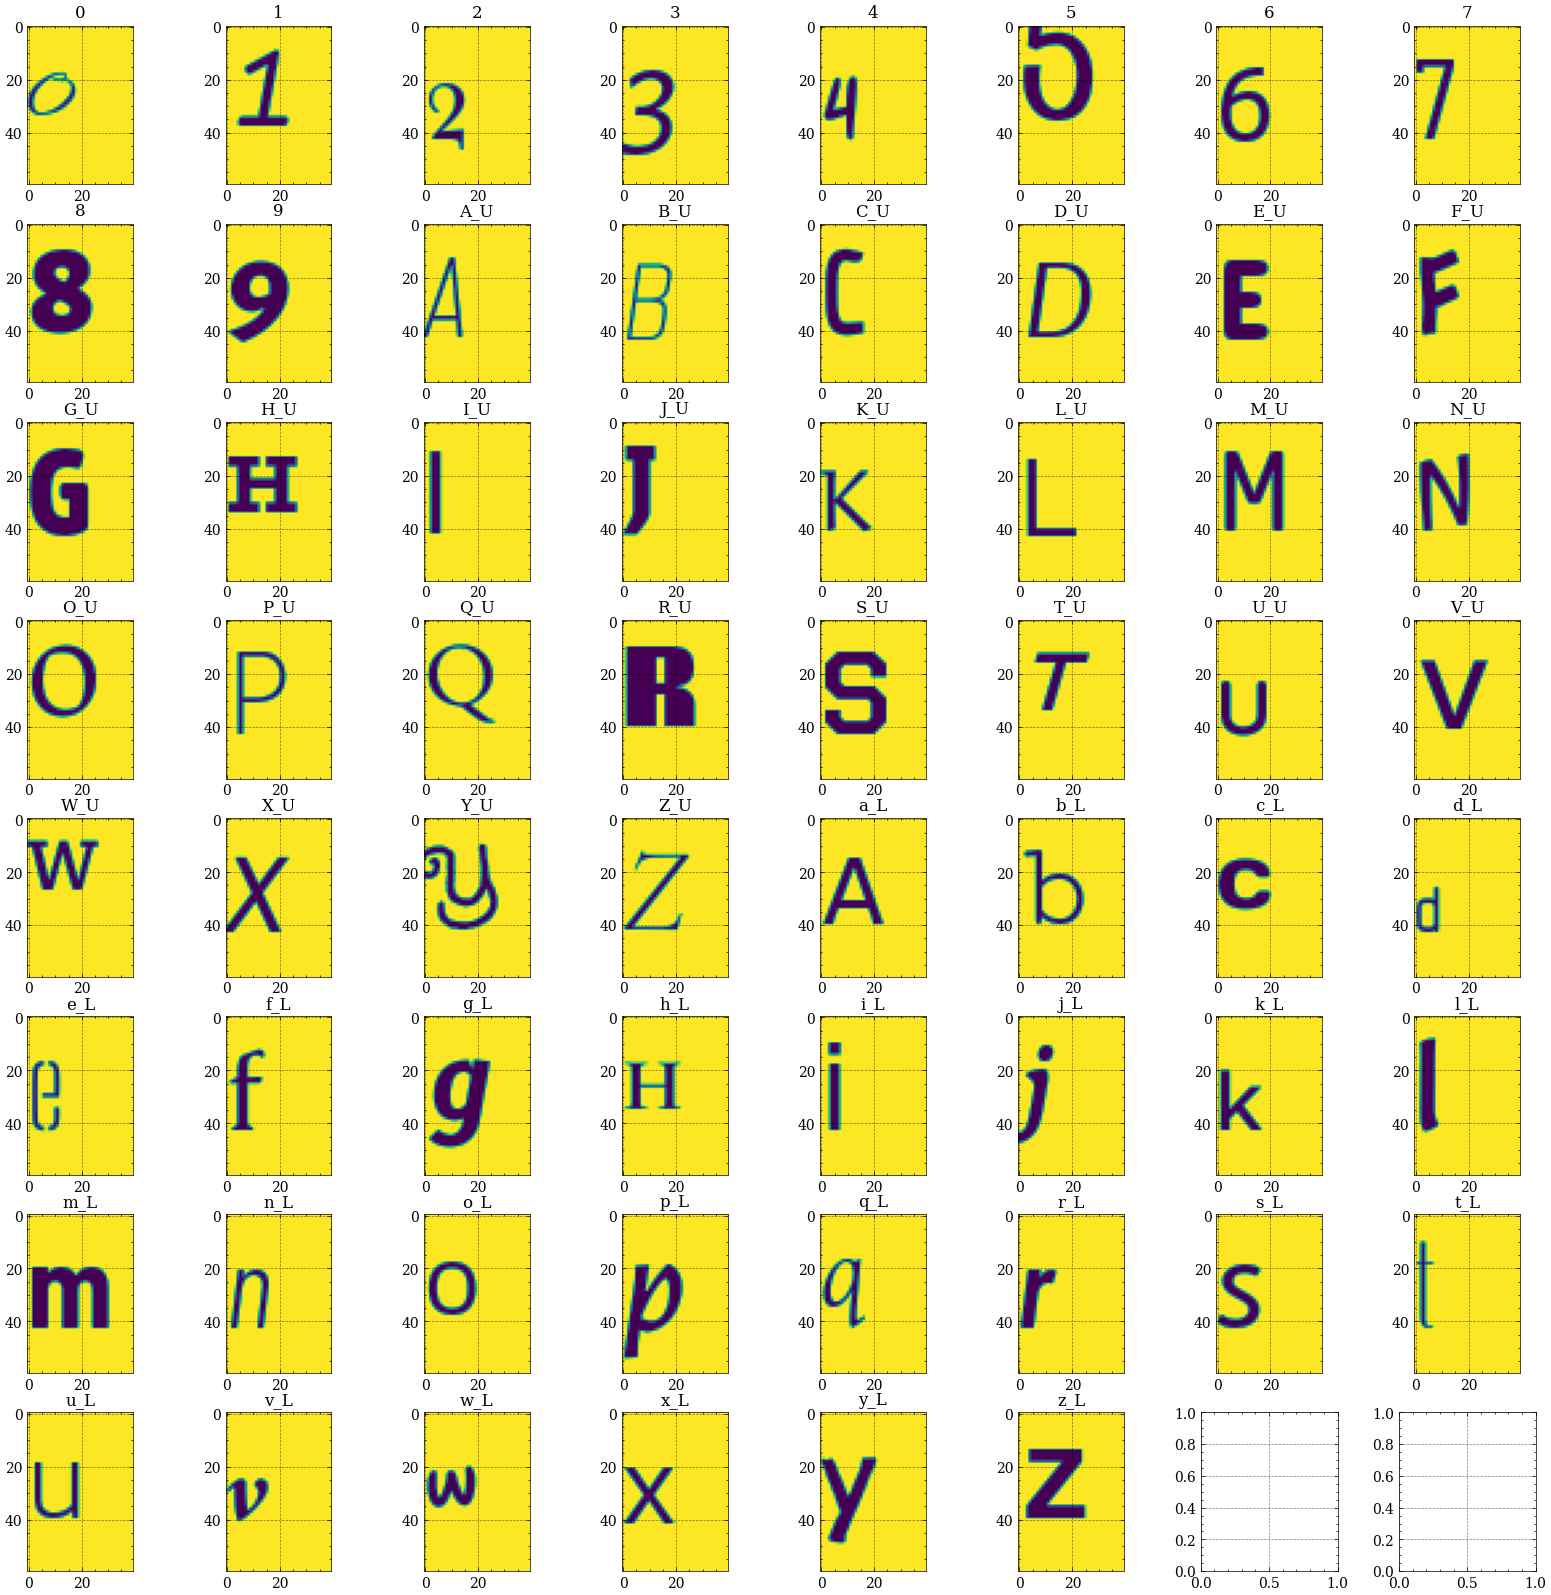

In [51]:
resize = tf.image.resize(tf.image.rgb_to_grayscale(images),(60,40))
plot_those_imgs(resize)

In [52]:
yhat = loaded_model.predict(*np.expand_dims(resize/255, 0))
yhat

array([[6.8634999e-01, 8.5230186e-06, 1.2345641e-04, ..., 4.9392107e-05,
        1.6051990e-07, 6.1255042e-07],
       [2.4056127e-14, 9.9787593e-01, 5.3143985e-06, ..., 1.8752072e-12,
        8.4492633e-19, 1.7099256e-11],
       [9.6515669e-07, 5.3697193e-05, 9.6225995e-01, ..., 1.2793006e-08,
        7.0496271e-06, 6.0698167e-05],
       ...,
       [6.9234636e-16, 6.7697415e-12, 9.9416222e-13, ..., 9.6333838e-01,
        1.8580414e-08, 1.2242209e-10],
       [2.4750308e-16, 1.0020730e-15, 2.6585963e-22, ..., 7.2782508e-13,
        9.9999952e-01, 6.3953932e-17],
       [7.1824492e-16, 2.3661584e-09, 2.5613739e-05, ..., 1.1966608e-10,
        6.5946515e-18, 1.9588540e-01]], dtype=float32)

['0.69 - 0', '1.0 - 1', '0.96 - 2', '1.0 - 3', '0.75 - 4', '0.26 - 0', '1.0 - 6', '1.0 - 7', '1.0 - 8', '1.0 - 9', '0.99 - A_U', '0.99 - B_U', '0.99 - C_U', '0.98 - D_U', '0.98 - E_U', '0.99 - F_U', '1.0 - G_U', '0.97 - H_U', '0.89 - l_L', '1.0 - J_U', '1.0 - K_U', '1.0 - L_U', '1.0 - M_U', '0.97 - N_U', '0.91 - O_U', '1.0 - P_U', '1.0 - Q_U', '0.86 - R_U', '1.0 - S_U', '0.99 - T_U', '0.87 - u_L', '0.99 - V_U', '1.0 - W_U', '1.0 - X_U', '0.28 - 3', '1.0 - Z_U', '0.59 - A_U', '1.0 - b_L', '1.0 - c_L', '0.65 - a_L', '0.6 - e_L', '1.0 - f_L', '1.0 - g_L', '0.99 - h_L', '1.0 - i_L', '1.0 - j_L', '0.98 - k_L', '1.0 - l_L', '1.0 - m_L', '1.0 - n_L', '0.97 - o_L', '1.0 - p_L', '0.95 - q_L', '1.0 - r_L', '1.0 - s_L', '0.82 - t_L', '0.99 - u_L', '0.98 - v_L', '1.0 - w_L', '0.96 - x_L', '1.0 - y_L', '0.8 - Z_U']


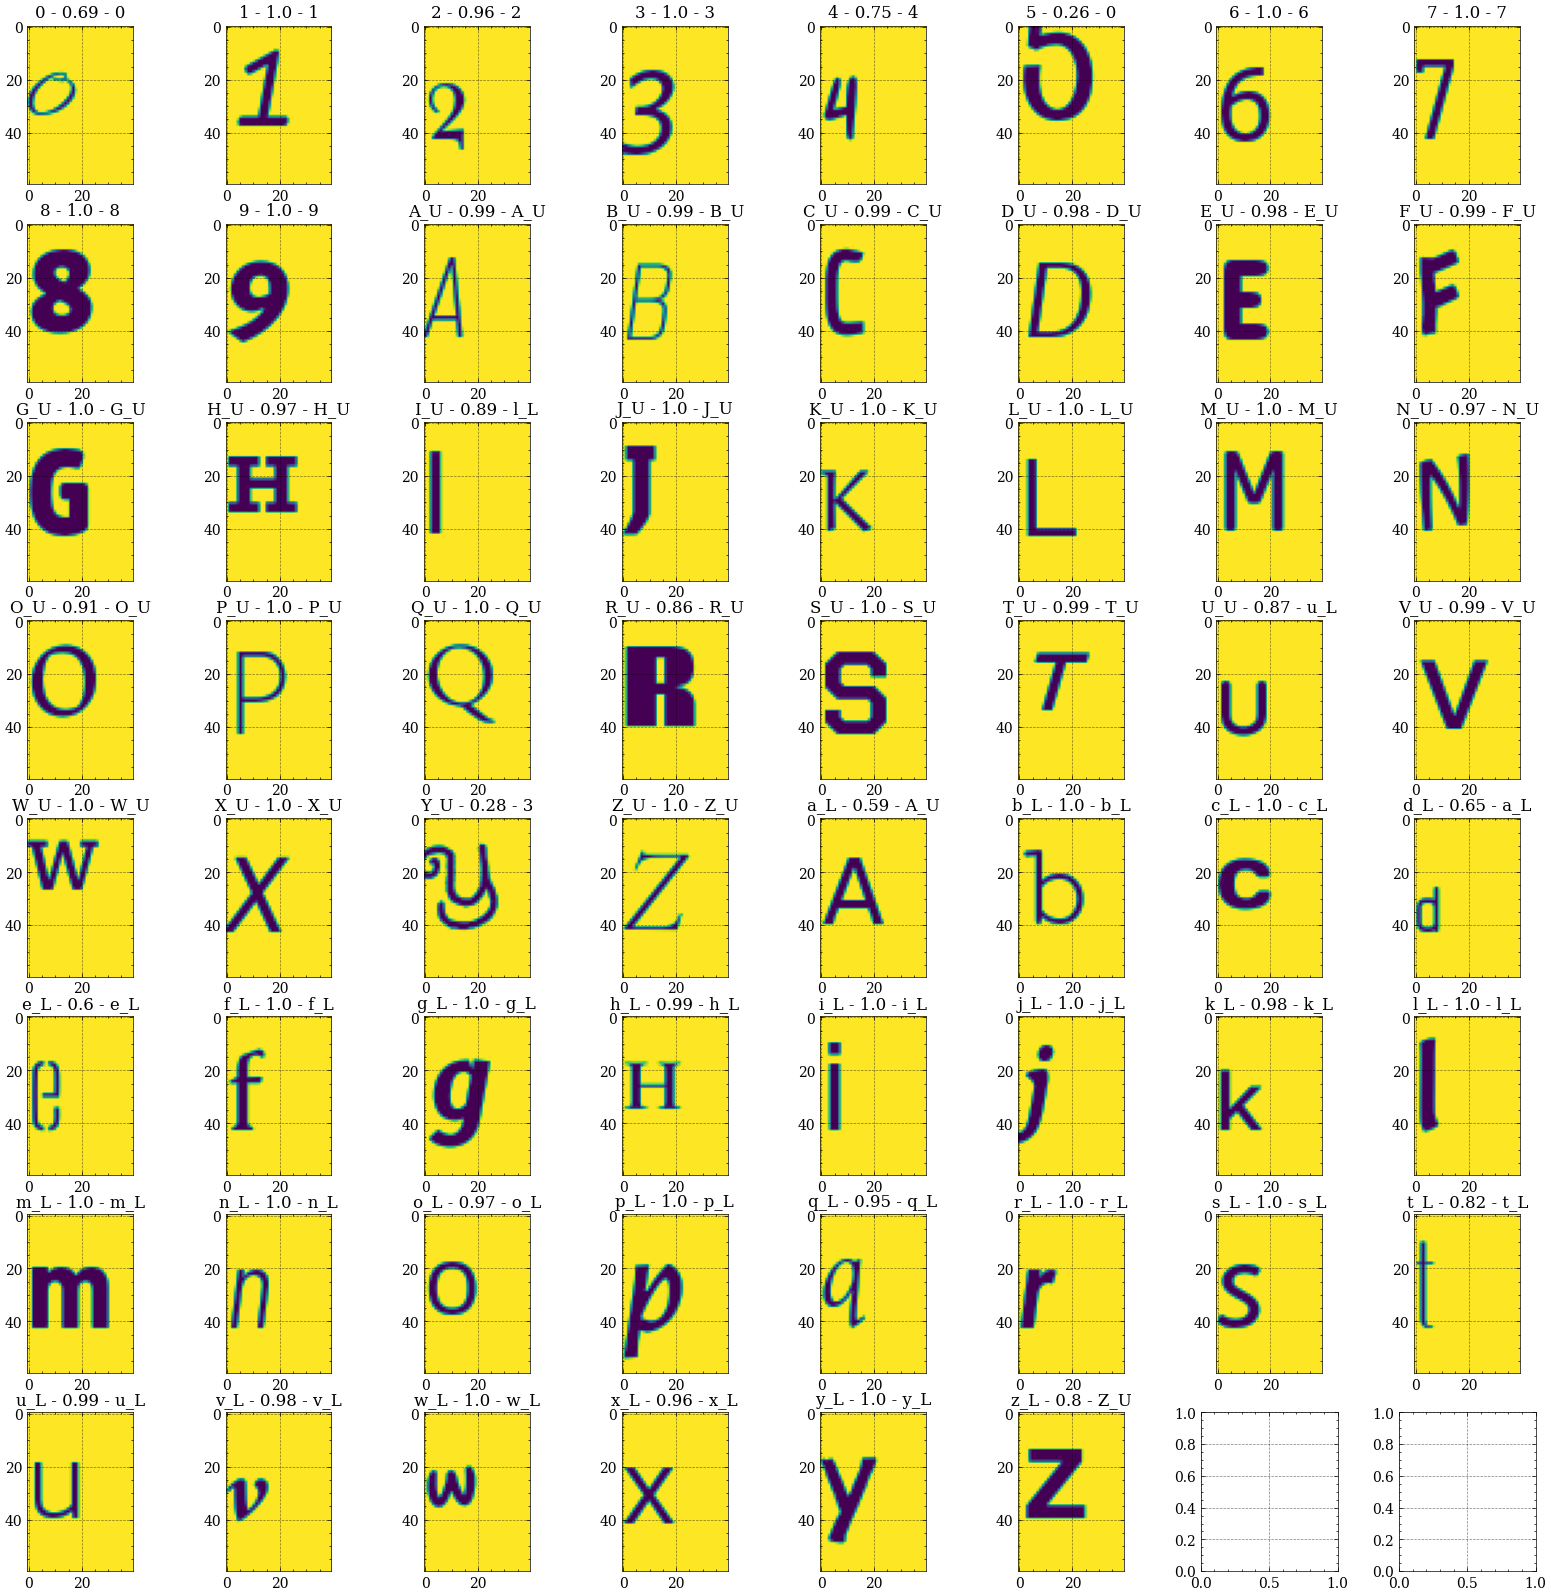

In [53]:
acc_pred = [f"{round(float(yhat[i][np.argmax(yhat[i])]),2)} - {class_names[np.argmax(yhat[i])]}" for i in range(len(yhat))]
print(acc_pred)
plot_those_imgs(resize,acc=acc_pred)